In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import datetime

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import Column, Integer, Float, Date, String, ForeignKey
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy import Index
from sqlalchemy import MetaData
from sqlalchemy import Table

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
inspector = inspect(engine) 
inspector.get_table_names()

columns = inspector.get_columns('measurement')

for c in columns:
    print(c['name'], c["type"])
    
twelve_month_data = engine.execute("select *from measurement where date >= '2017-06-04' order by date desc").fetchall()
#print(twelve_month_data)
#engine.execute('select *from station').fetchall()


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Calculate the date 1 year ago from today
last_date = twelve_month_data[0][2]
values = last_date.split('-')

#print(values)
last_year = dt.date(int(values[0]),int(values[1]),int(values[2])) - dt.timedelta(days=365)
print(last_year)

2016-08-23


In [12]:
# Perform a query to retrieve the data and precipitation scores
date_precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()
#print(date_precipitation)

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
date_precipitation_df = pd.DataFrame(date_precipitation)
#date_precipitation_df.head()

In [14]:
# Sort the dataframe by date
date_precipitation_df.sort_values(by=['date'])
date_precipitation_df.head(7)

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22
5,2016-08-24,2.15
6,2016-08-24,1.45


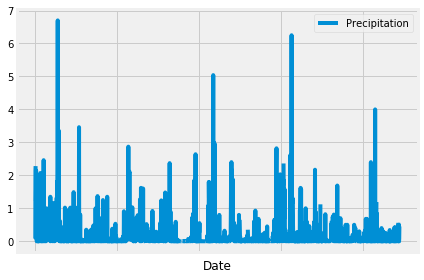

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
date_precipitation_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_precipitation_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# How many stations are available in this dataset?
station_count = engine.execute('select count(*) from station').fetchall()
print("There are", station_count[0][0], "stations.")

There are 9 stations.


In [18]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station,\
              func.count(Measurement.station))\
              .order_by(func.count(Measurement.station).desc())\
              .group_by(Measurement.station).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

active_stations = engine.execute('select station, count(*) from measurement group by station order by count(*) desc').fetchall()
#print(active_stations)

bussiest_station = active_stations[0][0]
records = session.query(Measurement.tobs).\
    filter(Measurement.station == bussiest_station).\
    order_by(Measurement.date).all()
y = [a for b in records for a in b] 
#print(y)

max_value = max(y) 
min_value = min(y) 
avg_value = sum(y)/len(y)

print(min_value, max_value, avg_value)

54.0 85.0 71.66378066378067


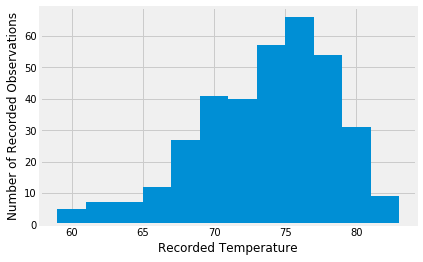

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

busy_last_date = session.query(Measurement.station, Measurement.date).filter(Measurement.station == bussiest_station).order_by(Measurement.date.desc()).first()
#print(busy_last_date)

values_last_date = busy_last_date[1].split('-')
#print(values_last_date)

busy_last_year = dt.date(int(values_last_date[0]),int(values_last_date[1]),int(values_last_date[2])) - dt.timedelta(days=365)
#print(busy_last_year)

temperature_twelve_months = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
   filter(Measurement.station == bussiest_station).\
   filter(Measurement.date > busy_last_year).\
   order_by(Measurement.date).all()

temp_busy_df=pd.DataFrame(temperature_twelve_months)
plt.hist(temp_busy_df['tobs'],12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Number of Recorded Observations")
plt.show()

In [21]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    start_date_query = datetime.datetime.strptime(start_date, "%Y-%m-%d") - datetime.timedelta(days=365)
    end_date_query = datetime.datetime.strptime(end_date, "%Y-%m-%d") - datetime.timedelta(days=365)

    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2017-06-04', '2017-06-19'))


[(72.0, 77.2, 83.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

temp_my_trip = (calc_temps('2016-06-04', '2016-06-19'))
print(temp_my_trip)


[(65.0, 75.08, 81.0)]


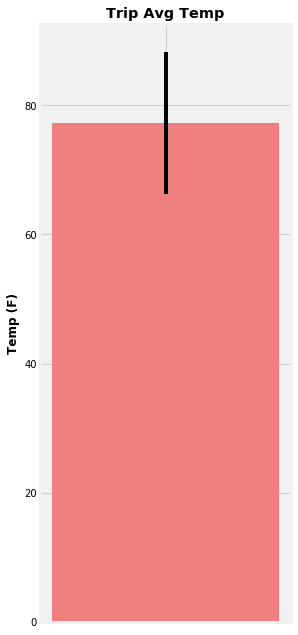

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_results = calc_temps('2017-06-04', '2017-06-19')
min_temp = (list(zip(*trip_results))[0])[0]
avg_temp = (list(zip(*trip_results))[1])[0]
max_temp = (list(zip(*trip_results))[2])[0]


plt.figure(figsize=(4,11))
plt.bar(1, avg_temp, yerr=(max_temp - min_temp), tick_label='', color='lightcoral')
plt.ylabel("Temp (F)", weight="bold")
plt.title("Trip Avg Temp", weight="bold")
plt.show()

In [25]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rain_records = engine.execute("SELECT m.station, SUM(m.prcp) AS precipitations, s.name, s.latitude, s.longitude, s.elevation \
                FROM Measurement m JOIN Station s ON m.station = s.station \
                WHERE m.date BETWEEN '2017-06-04' AND '2017-06-19' \
                GROUP BY m.station \
                ORDER BY precipitations DESC").fetchall()
rain_records_df = pd.DataFrame(rain_records)
rain_records_df


,0,1,2,3,4,5
0,USC00516128,6.80,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,3.26,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00513117,2.30,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00514830,2.12,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,USC00519523,0.62,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,USC00519397,0.19,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,USC00517948,NaN,"PEARL CITY, HI US",21.39340,-157.97510,11.9


Step 2 - Climate App

In [26]:
# Python SQL toolkit and Object Relational Mapper
import pandas as pd
import numpy as np
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import Session
from sqlalchemy import Column, Integer, String, Numeric, Text, Float
from sqlalchemy import create_engine, func, inspect

In [27]:
# database setup
engine1 = create_engine("sqlite:///hawaii.sqlite")

In [28]:
# Create conection to MySQL
session1 = Session(engine1)

In [29]:
from flask import Flask, jsonify

In [30]:
#calculate dates for the query.
end_date = dt.datetime(year=2017, month=6, day=19)
start_date = end_date - dt.timedelta(days=365)

In [31]:
# Use `declarative_base` from SQLAlchemy to model the tables as an ORM class
Base = declarative_base()

In [32]:
# query data set and build df

query = f"SELECT * FROM measurement WHERE date >= '{start_date}' AND date <= '{end_date}'"
df_query = pd.read_sql_query(query, session1.bind)

#df_query

In [33]:
# Routes
# /api/v1.0/precipitation
# Query for the dates and temperature observations from the last year
#app = Flask(__name__)

#@app.route('/api/v1.0/precipitation') 
def precipitation():
    print("Server received request for 'Precipitation' page...")
    return "These are the dates and temperature observations from last year."
  
    # create replica of df_query to remove unwanted columns but leave the original df for other queries
    df_query_tobs = df_query

    # removed unwanted columns
    df_query_tobs.drop('id', axis=1, inplace=True)
    df_query_tobs.drop('station', axis=1, inplace=True)
    df_query_tobs.drop('prcp', axis=1, inplace=True)
    
# Return the json representation dictionary. df to dictionary happening inside the argument of jsonify
    return jsonify(df_query_tobs.to_dict(orient='records'))

In [34]:
# Return a json list of stations from the dataset
#@app.route("/api/v1.0/stations")
def stations():
    print("Server received request for 'stations' page...")
    return "These are the list of stations that recorded dates and temperature observations from last year."
  
    query = f"SELECT DISTINCT station FROM measurement WHERE date >= '{start_date}' AND date <= '{end_date}'"
    
    # build df from query result
    df_query = pd.read_sql_query(query, session1.bind)
    
# Return the json representation dictionary. df to dictionary happening inside the argument of jsonify
    return jsonify(df_query.to_dict(orient='records'))

In [35]:
# /api/v1.0/tobs
# Return a json list of Temperature Observations (tobs) for the previous year
#@app.route('/api/v1.0/tobs') 
def tobs():
    print("Server received request for 'Temperature observations' page...")
    return "This is the list of Temperature observations (tobs) from previous year!"
    
    #calculate the dates for previous year for the query.
    start_date2 = start_date - dt.timedelta(days=365)
    end_date2 = end_date - dt.timedelta(days=365)
    
    query = f"SELECT tobs FROM measurement WHERE date >= '{start_date2}' AND date <= '{end_date2}'"
    
    # build df from query result
    df_query = pd.read_sql_query(query, session1.bind)
    
    return jsonify(df_query.to_dict(orient='records'))

In [36]:
# /api/v1.0/<start> and /api/v1.0/<start>/<end>
# Return a json list of the minimum temperature, the average temperature, and 
# the max temperature for a given start or start-end range.
#@app.route('/api/v1.0/<start>)') 
def tobs_start():
    print("Server received request for 'Minimum Temperature, Average Temperature, Maximum Temperature of a given start' page...")
    return "Here is the list of Temperature information for the given date!"
    
    query = f"SELECT MIN(tobs), MAX(tobs), AVG(tobs) FROM measurement WHERE date >= '{start_date}'"
    
    # build df from query result
    df_query = pd.read_sql_query(query, session1.bind)

    my_list = df_query["MIN(tobs)"].values
    min_tobs = my_list[0]

    my_list = df_query["MAX(tobs)"].values
    max_tobs = my_list[0]

    my_list = df_query["AVG(tobs)"].values
    avg_tobs = my_list[0]
    
    return jsonify(min_tobs, max_tobs, avg_tobs)

#@app.route('/api/v1.0/<start>/<end>') 
def tobs_given_range():
    
    print("Server received request for 'Minimum Temperature, Average Temperature, Maximum Temperature of a given start or date range' page...")
    return "Here is the list of Temperature information for the given date range!"
    
    query = f"SELECT MIN(tobs) FROM measurement WHERE date >= '{start_date}' AND date <= '{end_date}'"
    
    # build df from query result
    df_query = pd.read_sql_query(query, session1.bind)

    my_list = df_query["MIN(tobs)"].values
    min_tobs = my_list[0]

    my_list = df_query["MAX(tobs)"].values
    max_tobs = my_list[0]

    my_list = df_query["AVG(tobs)"].values
    avg_tobs = my_list[0]
    
    return jsonify(min_tobs, max_tobs, avg_tobs)